In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from file_cache import *


2020-05-27 23:00:31,289 util_log.py[153] INFO Start the program at:amax7, 127.0.1.1, with:Load module


File_cache: Adjust notebook work fold to:/share/felix/pj/brain_seg/


In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:

from file_cache import *

img_file_list = glob('/share/data2/body/brain/train/image/*CT*/**/*.*', recursive=True)

df = pd.DataFrame({'img_file':img_file_list})
df['p_id_path'] = df.img_file.apply(lambda val: os.path.dirname(val))
df['p_id'] = df['p_id_path'].rank(method='max').astype(int)
df.sort_values('p_id')
df['src'] = 'ct'
df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'label'))

df['valid'] = df.p_id%5 >=4

print(df.valid.value_counts())
df_ct = df.copy()

2020-05-27 23:00:34,768 utils.py[129] INFO Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-05-27 23:00:34,769 utils.py[141] INFO NumExpr defaulting to 8 threads.


False    980
True     406
Name: valid, dtype: int64


In [5]:
from file_cache import *

img_file_list = glob('/share/data2/body/brain/train/image/iNPH_MRI_PROCESSED/**/*.*', recursive=True)

df = pd.DataFrame({'img_file':img_file_list})
df['p_id_path'] = df.img_file.apply(lambda val: os.path.dirname(val))
df['p_id'] = df['p_id_path'].rank(method='max').astype(int)
df.sort_values('p_id')
df['src'] = 'mri'
df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'label'))

df['valid'] = df.p_id%5 >=4

print(df.valid.value_counts())

df_mri = df.copy()

False    826
True     187
Name: valid, dtype: int64


In [6]:
df = pd.concat([df_ct, df_mri])
df.groupby(['src', 'valid']).img_file.count()

src  valid
ct   False    980
     True     406
mri  False    826
     True     187
Name: img_file, dtype: int64

## Datasets

In [7]:
size =224
bs = 8
print('size, bs', size, bs)

size, bs 224 8


In [8]:
codes = range(5)

def get_y_fn(x):
    print(x)
    return x.replace('image', 'label')


src = (SegmentationItemList.from_df(df, path='/', cols='img_file' )
       .split_from_df(col='valid')
       #.label_from_func(get_y_fn, classes=codes)
       .label_from_df(cols='label_path', classes=codes)
      )
       #.label_from_func(cols='label_path', classes=codes))
    
print(len(src.train), len(src.valid))

#get_transforms()
data = (src.transform(None, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

1806 593


In [9]:
# tmp = df.groupby(['p_id', 'valid'], as_index=False).label_path.count()
# tmp.pivot_table(index='p_id', columns='valid', values='label_path').sort_values(0)

In [10]:
for a, b in data.dl(DatasetType.Train):
    break
    
a.shape

torch.Size([8, 3, 224, 224])

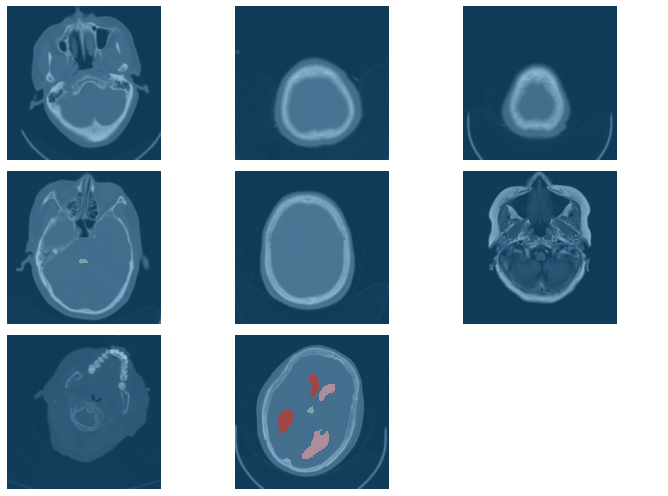

In [11]:
data.show_batch(4, figsize=(10, 7))

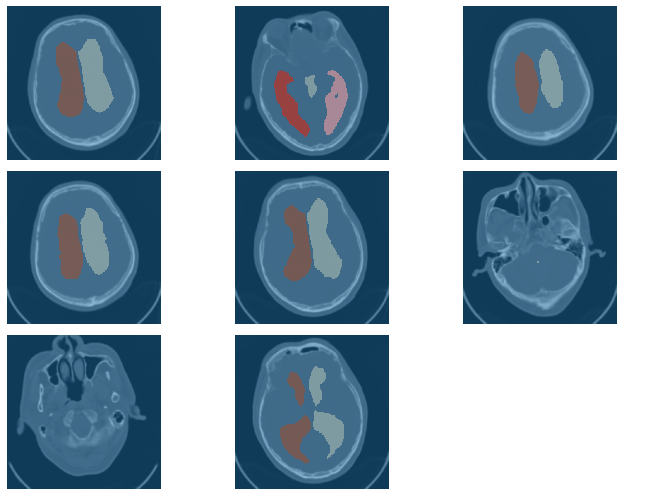

In [12]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [13]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [14]:
wd = 1e-2


In [15]:
print('abc')

abc


In [16]:
#多类别的Dice Metrics

from brain.metrics import * 

from functools import partial
def dice_fn(cls_id):
    fn = partial(dice_multiply, cls_id=cls_id) 
    fn.__name__ = f'dice_{cls_id}'
    return fn
 

metrics = [ dice_fn(i) for i in range(5) ] #, accuracy,

import ipdb
# ipdb.set_trace()
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

# for sn, child in enumerate(learn.model.children()):
#     print(sn, '===', child)

In [17]:
os.path.abspath('./output/model')

'/share/felix/pj/brain_seg/output/model'

In [18]:

learn.model_dir=os.path.abspath('./output/model')
os.makedirs(learn.model_dir, exist_ok=True)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


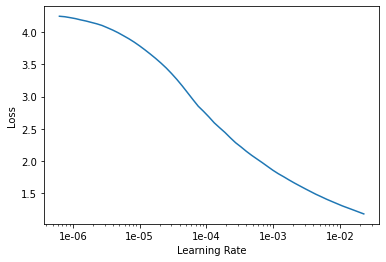

In [19]:
learn.recorder.plot()

In [20]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.113822,0.062610,0.990017,0.151746,0.567865,0.598426,0.651565,00:35
1,0.038678,0.035088,0.993288,0.732958,0.730250,0.902349,0.862193,00:34
2,0.028950,0.047316,0.992423,0.650350,0.688861,0.909421,0.863037,00:34
3,0.021390,0.021192,0.995962,0.805933,0.840105,0.925482,0.886661,00:34
4,0.014132,0.017859,0.996818,0.847607,0.869409,0.936323,0.908468,00:34


In [21]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.010802,0.017833,0.996931,0.851826,0.875511,0.942269,0.912121,00:35
1,0.010406,0.017813,0.996934,0.846274,0.870815,0.943574,0.914058,00:35
2,0.010126,0.017965,0.997024,0.857429,0.872072,0.945803,0.895770,00:50
3,0.011721,0.017634,0.997300,0.857637,0.877851,0.928433,0.861742,01:05
4,0.009099,0.015836,0.997455,0.866026,0.886547,0.949972,0.919438,01:05


In [22]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.006072,0.016902,0.997490,0.868362,0.885664,0.947537,0.924708,01:06
1,0.006156,0.018867,0.997462,0.867826,0.890616,0.951204,0.923549,01:06
2,0.005481,0.015675,0.997546,0.867434,0.893863,0.953128,0.921636,01:06
3,0.005270,0.019673,0.997461,0.868462,0.885454,0.948764,0.914482,01:06
4,0.005798,0.017510,0.997554,0.858953,0.881502,0.949374,0.926021,01:05
5,0.005766,0.018438,0.997571,0.869930,0.896498,0.950149,0.923800,01:06
6,0.006037,0.019666,0.997523,0.883990,0.884703,0.945251,0.919031,01:06
7,0.005662,0.016510,0.997602,0.864559,0.873503,0.924943,0.920297,01:06
8,0.005374,0.019621,0.997542,0.856715,0.896995,0.943941,0.917506,01:06
9,0.004212,0.019364,0.997827,0.884981,0.901437,0.951445,0.928834,01:06


In [24]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.003514,0.019135,0.997842,0.887171,0.905313,0.952716,0.930391,01:06
1,0.003511,0.020646,0.997819,0.887746,0.906433,0.955550,0.931651,01:06
2,0.003464,0.020735,0.997787,0.883534,0.904988,0.952960,0.931244,01:07
3,0.003514,0.020503,0.997802,0.882768,0.904032,0.956271,0.929592,00:37
4,0.003849,0.017468,0.997749,0.874964,0.875419,0.939818,0.923482,00:36
5,0.003695,0.018658,0.997781,0.880117,0.902626,0.947627,0.922913,00:36
6,0.004391,0.020768,0.997674,0.887508,0.901070,0.948954,0.923706,00:36
7,0.004144,0.023171,0.997561,0.888759,0.895219,0.949454,0.925719,00:36
8,0.004068,0.017635,0.997748,0.870260,0.892410,0.941031,0.912940,00:36
9,0.003203,0.019284,0.997843,0.883368,0.901793,0.954189,0.932708,00:35


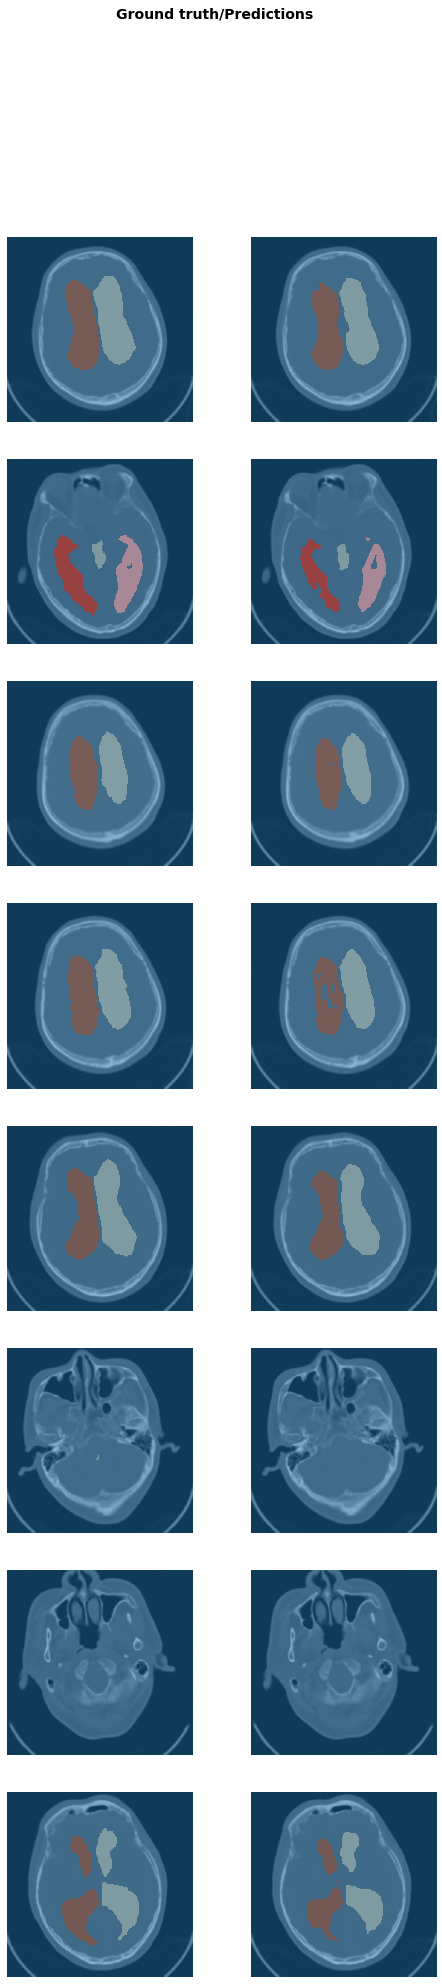

In [23]:
learn.show_results(DatasetType.Valid, rows=40)
